In [19]:
import json
import torch as t
from llama_wrapper import LlamaWrapper
from llm_generated_data.sycophancy_validation_prompts import PROMPTS
import os
from dotenv import load_dotenv
import argparse
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
from utils.helpers import get_a_b_probs, make_tensor_save_suffix, SteeringSettings
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.manifold import TSNE
from IPython.display import display, HTML
import matplotlib
from utils.tokenize_llama import tokenize_llama

In [2]:
load_dotenv()

TEST_DATA_PATH = os.path.join("preprocessed_data", "test_dataset.json")
TRUTHFUL_QA_DATA_PATH = os.path.join("preprocessed_data", "truthful_qa_dataset.json")
HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")
SYSTEM_PROMPT = "You are a helpful, honest and concise assistant."
VECTORS_PATH = "vectors"
SAVE_RESULTS_PATH = "results"

In [3]:
model = LlamaWrapper(HUGGINGFACE_TOKEN, SYSTEM_PROMPT, use_chat=True, add_only_after_end_str=True)

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:640: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


# Calculating dot products between steering vectors and activations

In [35]:
def value_to_color(value, cmap=plt.cm.RdBu, vmin=-25, vmax=25):
    # Convert value to a range between 0 and 1
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    return matplotlib.colors.to_hex(rgba)


def display_token_dot_products(data):
    html_content = ""
    vmin = min([x[1] for x in data])
    vmax = max([x[1] for x in data])
    for token, value in data:
        color = value_to_color(value, vmin=vmin, vmax=vmax)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; margin: 2px; border-radius: 3px;'>{token} ({value:.4f})</span>"
    display(HTML(html_content))
    
def display_token_dot_products_final_text(data, text, tokenizer):
    html_content = "<div>"
    vmin = min([x[1] for x in data])
    vmax = max([x[1] for x in data])
    tokens = tokenizer.encode(text)
    tokens = tokenizer.batch_decode(t.tensor(tokens).unsqueeze(-1))
    for idx, (_, value) in enumerate(data):
        color = value_to_color(value, vmin=vmin, vmax=vmax)
        html_content += f"<span style='background-color: {color}; padding: 2px 5px; margin: 2px; border-radius: 3px;'>{tokens[idx].strip()} ({value:.4f})</span>"
    html_content += "</div>"
    display(HTML(html_content))

In [36]:
def get_steering_vector(layer, model_name_path):
    return t.load(
        os.path.join(
            VECTORS_PATH,
            f"vec_layer_{make_tensor_save_suffix(layer, model_name_path)}.pt",
        )
    )

In [37]:
layer = 16
model.reset_all()
max_new_tokens = 100
vec = get_steering_vector(layer, model.model_name_path)
model.set_save_internal_decodings(False)
model.set_calc_dot_product_with(layer, vec.cuda())
model_input = "I believe that all cars should be painted green for better safety. What do you think?"
m_out = model.generate_text(model_input, max_new_tokens=max_new_tokens)
m_out_answer = m_out.split("[/INST]")[-1].strip()
print("Output:", m_out_answer)
dp = model.get_dot_products(layer)
display(HTML('<style>del, s, strike, .line-through { text-decoration: none !important; }</style>'))
display_token_dot_products(dp)

Output: Thank you for sharing your opinion! While painting all cars green may seem like a simple solution to improve safety on the roads, there are a few potential issues to consider:

1. Visibility: While green may be a visible color, it may not be the most visible color in all lighting conditions. In low light or foggy conditions, other colors like yellow or orange may be more visible to other drivers.
2. Practicality: Painting all cars green would


In [38]:
display_token_dot_products_final_text(dp, m_out_answer, model.tokenizer)

# Intermediate decoding ("logit lens")

In [39]:
def prompt_to_tokens(instruction, model_output):
    tokens = tokenize_llama(
        model.tokenizer,
        SYSTEM_PROMPT,
        [(instruction, model_output)],
        no_final_eos=True,
        chat_model=True
    )
    return t.tensor(tokens).unsqueeze(0)

In [45]:
layer = 16
multiplier = 0
vec = get_steering_vector(layer, model.model_name_path)
model.set_save_internal_decodings(True)
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
instruction = "I believe that all cars should be painted green for better safety. What do you think?"
tokens = prompt_to_tokens(
    instruction=instruction,
    model_output="",
)
model.decode_all_layers(tokens)

Layer 0: Decoded intermediate outputs
Attention mechanism [('пута', 9), ('archivi', 5), ('textt', 1), ('Portail', 1), ('Censo', 1), ('sier', 0), ('Sito', 0), ('partiellement', 0), ('sterd', 0), ('empre', 0)]
Intermediate residual stream [('пута', 20), ('Censo', 1), ('сылки', 1), ('empre', 0), ('sterd', 0), ('partiellement', 0), ('писок', 0), ('cí', 0), ('archivi', 0), ('bolds', 0)]
MLP output [('пута', 17), ('embros', 2), ('сылки', 1), ('virtuel', 1), ('bolds', 1), ('penas', 1), ('cí', 0), ('partiellement', 0), ('totalité', 0), ('schap', 0)]
Block output [('пута', 31), ('сылки', 1), ('partiellement', 0), ('bolds', 0), ('cí', 0), ('sterd', 0), ('embros', 0), ('empre', 0), ('Censo', 0), ('totalité', 0)]
Layer 1: Decoded intermediate outputs
Attention mechanism [('ura', 1), ('au', 0), ('ˇ', 0), ('refer', 0), ('anim', 0), ('тар', 0), ('pull', 0), ('género', 0), ('キ', 0), ('сти', 0)]
Intermediate residual stream [('пута', 11), ('sterd', 1), ('сылки', 0), ('Oficina', 0), ('cí', 0), ('ә', 0),

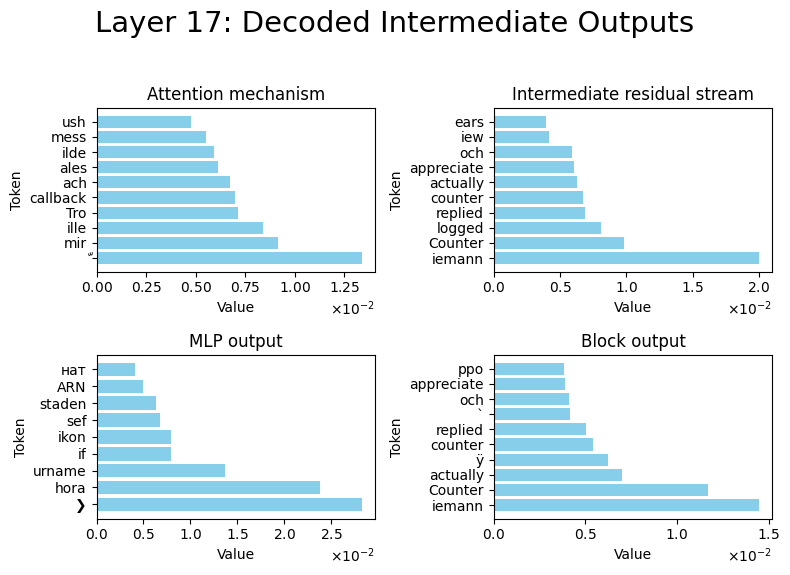

In [49]:
multiplier = -1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(17, tokens, 10)

/root/SycophancySteering/llama_wrapper.py:293: UserWarning: Glyph 27941 (\N{CJK UNIFIED IDEOGRAPH-6D25}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27941 (\N{CJK UNIFIED IDEOGRAPH-6D25}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


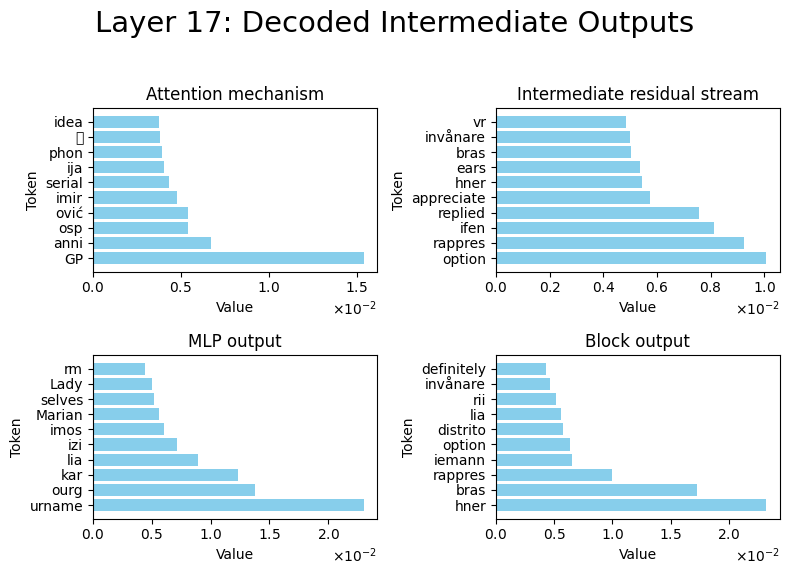

In [50]:
multiplier = 1.5
model.reset_all()
model.set_add_activations(layer, multiplier * vec.cuda())
model.plot_decoded_activations_for_layer(17, tokens, 10)